In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from sklearn import preprocessing
import pandas_ta
import talib.abstract as talib

In [2]:
# For styling purposes
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [3]:
# The goal: To make daily predictions of stock return direction of a specific stock
# The approach: Use technical analysis, market data and interest data to complete the binary classification problem
# Inputs are obtained from https://www.sciencedirect.com/science/article/pii/S2405918820300143 with several tweaks

In [4]:
# https://www.sciencedirect.com/science/article/pii/S2405918820300143#appsec1.1
# I choose to use this article for guidance because the models displayed strong predictive power for both short and long term forecasts
# Most features used were from the suggestions of this article

In [5]:
# Example of getting data from fred
from fredapi import Fred
# key = '' # key here
fred = Fred(api_key=key)
data = fred.get_series('SP500')
data

2012-04-30    1397.91
2012-05-01    1405.82
2012-05-02    1402.31
2012-05-03    1391.57
2012-05-04    1369.10
               ...   
2022-04-22    4271.78
2022-04-25    4296.12
2022-04-26    4175.20
2022-04-27    4183.96
2022-04-28    4287.50
Length: 2609, dtype: float64

In [6]:
# yahoo finance example
import yfinance as yf
yf.Ticker('MMM').history(period="10Y")["Close"]

Date
2012-04-30     67.640648
2012-05-01     67.822296
2012-05-02     67.761742
2012-05-03     67.663345
2012-05-04     67.118332
                 ...    
2022-04-25    148.600006
2022-04-26    144.220001
2022-04-27    144.210007
2022-04-28    147.139999
2022-04-29    145.440002
Name: Close, Length: 2518, dtype: float64

In [7]:
# tickers = [['MSFT'],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GSPC', '^GDAXI', '^FTSE', 'GOOG', 'AAPL']] # msft
tickers = [['^GSPC'],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', 'GBPUSD=X', '^DJI']] # SP500

def marketInformation(time, tickers):
    hist = yf.Ticker(tickers[0][0]).history(period=time)["Close"]
    hist = hist.rename(tickers[0][0])
    hist = np.log(hist / hist.shift(periods=1))
    hist = hist.to_frame()
    
    for t in tickers[1]:
        next = yf.Ticker(t).history(period=time)["Close"].rename(t)
        next = np.log(next / next.shift(periods=1))
        next = next.to_frame()
        hist = hist.merge(next, on='Date', how='left')
    for t in ['^VIX', '^MOVE']:
        next = yf.Ticker(t).history(period=time)["Close"].rename(t)
        next = next.to_frame()
        hist = hist.merge(next, on='Date', how='left')
    return hist

x1 = marketInformation("10Y", tickers)
x1

C:\Users\zhux2\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,^GSPC,EURUSD=X,JPY=X,ZC=F,HG=F,CL=F,GC=F,^GDAXI,^FTSE,SI=F,GBPUSD=X,^DJI,^VIX,^MOVE
Date,,,,,,,,,,,,,,
2012-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.150000,62.900002
2012-05-01,0.005642,-0.000132,-0.005353,-0.000758,0.001694,0.012226,-0.001023,NaN,0.012883,-0.002652,-0.002926,0.004959,16.600000,67.000000
2012-05-02,-0.002500,0.000000,0.003610,-0.026883,-0.014294,-0.008894,-0.005007,-0.007485,-0.009352,-0.009273,-0.000649,-0.000810,16.879999,65.099998
2012-05-03,-0.007688,-0.006993,-0.001110,0.013148,-0.013832,-0.025800,-0.011680,-0.002436,0.001475,-0.020909,-0.001864,-0.004682,17.559999,63.299999
2012-05-04,-0.016279,0.000658,0.001110,0.017518,-0.002548,-0.040298,0.006405,-0.020063,-0.019525,0.013955,-0.000065,-0.012827,19.160000,57.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.005682,-0.002230,0.001533,0.009101,-0.029565,-0.035196,-0.019770,-0.015529,-0.018951,-0.024581,-0.015113,0.007016,27.020000,131.630005
2022-04-26,-0.028550,-0.008998,-0.006717,0.003742,-0.002025,0.031565,0.004322,-0.012122,0.000772,-0.005338,-0.007109,-0.024055,33.520000,129.270004
2022-04-27,0.002096,-0.006610,-0.003749,0.015135,0.003260,0.003142,-0.008185,0.002725,0.005320,-0.003574,-0.012320,0.001856,31.600000,130.110001


In [8]:
def technicalInformation(time, ticker):
    hist = yf.Ticker(ticker).history(period=time)
    hist["HighLow"] = hist["High"] - hist["Low"]
    hist["Trade"] = np.log(hist["Volume"] / hist["Volume"].shift(periods=1))
    hist["return2"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 2
    hist["return3"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 3
    hist["return4"] = np.log(hist["Close"] / hist["Close"].shift(periods=1)) ** 4
    hist["MovingAvg"] = hist["Close"].rolling(window=10).mean()
    hist["Momentum"] = hist["Close"] - hist["Close"].shift(periods=10)
    hist["Stochastic%k"] = (hist["Close"] - hist["Low"].rolling(window=10).min()) / (hist["High"].rolling(window=10).max() - hist["Low"].rolling(window=10).min())
    hist["Stochastic%d"] = hist["Stochastic%k"].rolling(window=10).mean()
    hist["RSI"] = talib.RSI(hist["Close"], timeperiod=14)
    hist["William%r"] = (hist["High"].rolling(window=10).max() - hist["Close"]) / (hist["High"].rolling(window=10).max() - hist["Low"].rolling(window=10).min())
    hist.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
    hist["MACD"] = hist["MACDh_12_26_9"]
    hist = hist.drop(columns=['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
    return hist
    
x2 = technicalInformation("10Y", tickers[0][0])
x2

,HighLow,Trade,return2,return3,return4,MovingAvg,Momentum,Stochastic%k,Stochastic%d,RSI,William%r,MACD
Date,,,,,,,,,,,,
2012-04-30,9.260010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-01,19.589966,0.063403,0.000032,1.796387e-07,1.013600e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-02,11.579956,-0.001075,0.000006,-1.562135e-08,3.905035e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-03,14.359985,0.051505,0.000059,-4.544641e-07,3.494080e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-04,23.550049,-0.007461,0.000265,-4.314027e-06,7.022802e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,98.200195,0.032639,0.000032,1.834213e-07,1.042157e-09,4392.406982,-192.159668,0.305332,0.200613,39.271933,0.694668,-23.778967
2022-04-26,103.100098,-0.076916,0.000815,-2.327120e-05,6.643929e-07,4368.674023,-237.329590,0.000474,0.198848,32.740454,0.999526,-31.750666
2022-04-27,77.810059,0.030361,0.000004,9.206191e-09,1.929479e-11,4347.325000,-213.490234,0.060165,0.198327,33.601970,0.939835,-34.427624


In [9]:
def interestInformation(ticker):
    hist = yf.Ticker(ticker).history(period="10Y")["Close"]
    hist = hist.rename(ticker)
    hist = np.log(hist / hist.shift(periods=1))
    hist = hist.to_frame()
    
    tickers = ['EFFR', 'DGS3MO', 'DGS10', 'DGS30', 'DAAA', 'DBAA']
    for t in tickers:
        data = fred.get_series(t).rename(t)
        data.index.name = 'Date'
        data = data.to_frame()
        hist = hist.merge(data, on='Date', how='left')
    hist["FFR"] = hist["EFFR"] - hist["EFFR"].shift(periods=1)
    hist["3mTbill"] = hist["DGS3MO"] - hist["DGS3MO"].shift(periods=1)
    hist["10yBond"] = hist["DGS10"] - hist["DGS10"].shift(periods=1)
    hist["30yBond"] = hist["DGS30"] - hist["DGS30"].shift(periods=1)
    hist["AAA"] = hist["DAAA"] - hist["DAAA"].shift(periods=1)
    hist["BAA"] = hist["DBAA"] - hist["DBAA"].shift(periods=1)
    hist["TermSpread"] = hist["DGS10"] - hist["DGS3MO"]
    hist["LongSpread"] = hist["DGS30"] - hist["DGS10"]
    hist["MoodySpread"] = hist["DBAA"] - hist["DAAA"]
    hist["CorpVsGov"] = hist["DAAA"] - hist["DGS10"]
    hist = hist.drop(columns=[ticker, 'EFFR', 'DGS3MO', 'DGS10', 'DGS30', 'DAAA', 'DBAA'])
    return hist

x3 = interestInformation(tickers[0][0])
x3

,FFR,3mTbill,10yBond,30yBond,AAA,BAA,TermSpread,LongSpread,MoodySpread,CorpVsGov
Date,,,,,,,,,,
2012-04-30,NaN,NaN,NaN,NaN,NaN,NaN,1.85,1.17,1.20,2.00
2012-05-01,0.00,-0.01,0.03,0.04,0.05,0.05,1.89,1.18,1.20,2.02
2012-05-02,-0.01,-0.01,-0.02,-0.05,-0.05,-0.05,1.88,1.15,1.20,1.99
2012-05-03,0.00,0.01,0.00,0.01,0.00,-0.01,1.87,1.16,1.19,1.99
2012-05-04,0.01,-0.02,-0.05,-0.05,-0.04,-0.04,1.84,1.16,1.19,2.00
...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.00,0.08,-0.09,-0.07,-0.04,-0.02,1.90,0.07,0.92,1.11
2022-04-26,0.00,-0.08,-0.04,-0.02,0.00,-0.01,1.94,0.09,0.91,1.15
2022-04-27,0.00,-0.01,0.05,0.05,0.05,0.04,2.00,0.09,0.90,1.15


In [10]:
# Extensive technical analysis
import ta
from ta.utils import dropna

def technical2(time, ticker):
    to_drop = ['High', 'Low', 'Dividends', 'Stock Splits', 'SMA', 'TVB']
    hist = yf.Ticker(ticker).history(period=time)
    
#     ta_ALL = add_all_ta_features(hist, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
#     print(ta_ALL.columns)
    
    inputs = {
    'open': hist["Open"],
    'high': hist["High"],
    'low': hist["Low"],
    'close': hist["Close"],
    'volume': hist["Volume"]
    }
    high = hist["High"]
    low = hist["Low"]
    open = hist["Open"]
    close = hist["Close"]
    volume = hist["Volume"]
    hist["SMA"] = talib.SMA(hist["Close"], timeperiod=30)
    hist["WMA"] = talib.WMA(hist["Close"], timeperiod=30)
    hist["EMA"] = talib.EMA(hist["Close"], timeperiod=30)
    _, hist["SlowStochastic%D"] = talib.STOCH(inputs, 5, 3, 0, 3, 0)
    hist["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    hist["CCIndex"] = talib.CCI(high, low, close, timeperiod=10)
    hist["ROC"] = talib.ROC(close, timeperiod=10)
    hist["Disparity"] = (hist["Close"] - hist["SMA"]) / hist["SMA"]
    hist["APO"] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    hist["PsychologicalLine"] = (hist["Close"].rolling(2).rank() - 1).rolling(10).sum()
    hist["PLUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=10)
    hist["MINUS_DI"] = talib.MINUS_DI(high, low, close, timeperiod=10)
    hist["ATR"] = talib.ATR(high, low, close, timeperiod=10)
    hist["UpperBBand"], _, hist["LowerBBand"] = talib.BBANDS(close, timeperiod=5, nbdevup=2., nbdevdn=2., matype=0)
    hist["DX"] = talib.DX(high, low, close, timeperiod=10)
    hist["KeltnerHBand"] = ta.volatility.KeltnerChannel(high=high, low=low, close=close, fillna=True).keltner_channel_hband()
    hist["KeltnerLBand"] = ta.volatility.KeltnerChannel(high=high, low=low, close=close, fillna=True).keltner_channel_lband()
    hist["TRIMA"] = talib.TRIMA(close, timeperiod=30)
    hist["MAEnvelopeU"] = hist["SMA"] * 1.05
    hist["MAEnvelopeL"] = hist["SMA"] * 0.95
    hist["TVB"] = close * 3 - (low + open + high)
    hist["RexOscillator"] = hist["TVB"].rolling(10).mean()
    hist["NVI"] = ta.volume.NegativeVolumeIndexIndicator(close=close, volume=volume, fillna=True).negative_volume_index()
    hist.ta.pvi(volume='Volume', append=True)
    hist.ta.vwma(volume='Volume', append=True)
    hist["VolumeMomentum"] = volume - volume.shift(periods=10)
    hist["ROCP"] = talib.ROCP(close, timeperiod=10)
    hist["PPO"] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    hist["ParabolicSAR"] = talib.SAR(high, low, acceleration=0., maximum=0.)
    hist["OBV"] = talib.OBV(close, volume)
    hist["MFI"] = talib.MFI(high, low, close, volume, timeperiod=10)
    hist["LINEARREG_SLOPE"] = talib.LINEARREG_SLOPE(close, timeperiod=10)
    hist = hist.drop(columns=to_drop)
    return hist

x4 = technical2("10Y", tickers[0][0])
x4

,Open,Close,Volume,WMA,EMA,SlowStochastic%D,ADOSC,CCIndex,ROC,Disparity,...,NVI,PVI_1,VWMA_10,VolumeMomentum,ROCP,PPO,ParabolicSAR,OBV,MFI,LINEARREG_SLOPE
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-30,1403.260010,1397.910034,3574010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000.000000,1000.000000,NaN,NaN,NaN,NaN,NaN,3.574010e+09,NaN,NaN
2012-05-01,1397.859985,1405.819946,3807950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000.000000,1000.565838,NaN,NaN,NaN,NaN,1394.000000,7.381960e+09,NaN,NaN
2012-05-02,1405.500000,1402.310059,3803860000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,997.503316,1000.565838,NaN,NaN,NaN,NaN,1415.319946,3.578100e+09,NaN,NaN
2012-05-03,1402.319946,1391.569946,4004910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,997.503316,999.799951,NaN,NaN,NaN,NaN,1415.319946,-4.268100e+08,NaN,NaN
2012-05-04,1391.510010,1369.099976,3975140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,981.396422,999.799951,NaN,NaN,NaN,NaN,1415.319946,-4.401950e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,4255.339844,4296.120117,4061070000,4448.349425,4427.971973,36.157195,-2.197423e+09,-191.411035,-4.281366,-0.034925,...,9181.446490,898.842440,4388.848838,6.080300e+08,-0.042814,-1.460171,1266.739990,6.966886e+11,28.498559,-11.641983
2022-04-26,4278.140137,4175.200195,3760420000,4430.517673,4411.664116,19.390259,-2.819451e+09,-160.422903,-5.378538,-0.062103,...,8923.022666,898.842440,4364.484783,3.078800e+08,-0.053785,-1.822475,1266.739990,6.929282e+11,28.401704,-22.148106
2022-04-27,4186.520020,4183.959961,3876340000,4413.246572,4396.973526,13.053249,-3.383331e+09,-120.214325,-4.854864,-0.059583,...,8923.022666,899.052245,4342.349935,4.243500e+08,-0.048549,-2.156903,1266.739990,6.968045e+11,28.220816,-30.305007


In [29]:
# All features are now combined and standardized
# At this point the lastest 2 days need to be trimmed, due to fred at times updating data 2 days after yahoo finance
# The first 50 days are also trimmed for missing values in MACD and RSI

def allFactors(x1, x2, x3, x4, ticker):
    X = x1.merge(x2.merge(x3.merge(x4, on='Date', how='left'), on='Date', how='left'), on='Date', how='left')
    X = X.fillna(X.mean())
    X.dropna(inplace=True)
    X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float64)
    y = X[ticker].shift(periods=-1)
    y = y.iloc[50:-2]
    y = 1*(y > 0)
    y = y.to_numpy()
    X = X.iloc[50:-2, :]
    X = X.to_numpy()
    
    scaler = preprocessing.StandardScaler().fit(X[0:1500, :])
    X = scaler.transform(X)
    return X, y

Xp, yp = allFactors(x1, x2, x3, x4, tickers[0][0])
Xtrain = Xp[0:1500, :]
ytrain = yp[0:1500]

In [30]:
# Here features are recursively eliminated using Xtrain and ytrain until only 40 are left

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
import imblearn

def rfe(Xtrain, ytrain, X, y):
    selector = RFE(RandomForestClassifier(n_estimators=300, max_depth=40, min_samples_leaf=300, random_state=1), n_features_to_select=40, step=5)
    selector = selector.fit(Xtrain, ytrain)
    X = X[:, selector.support_]
    return X, y

Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
Xtrain = Xp[0:1500, :]
ytrain = yp[0:1500]
Xval = Xp[1500:1900, :]
yval = yp[1500:1900]
Xtest = Xp[1900:2400, :]
ytest = yp[1900:2400]

In [13]:
def slidingWindow(a, period, size):
    shape = a.shape[0]
    a = a.flatten()
    index = np.arange(size*period)[None, :] + size*np.arange(shape - period + 1)[:, None]
    return a[index]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy

model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain))
print(model.score(Xval, yval))

0.5466666666666666
0.565


In [15]:
def modelVal(model, Xval):
    t = 0.5
    pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    while (pred.mean() > 0.67):
        t += 0.01
        pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    while (pred.mean() < 0.33):
        t -= 0.01
        pred = (model.predict_proba(Xval)[:,1] >= t).astype(bool)
    return t

In [16]:
# This will test if including more days of input will increase prediction accuracy

def slidingWindowTest(Xp, yp):
    score = [list(), list(), list(), list()]
    for i in range(1, 11):
        X = slidingWindow(Xp, i, Xp.shape[1])
        y = yp[i-1:]
        Xtrain = X[0:1500, :]
        ytrain = y[0:1500]
        Xval = X[1500:1900, :]
        yval = y[1500:1900]
        Xtest = X[1900:2400, :]
        ytest = y[1900:2400]
        ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
        if(ratio < 0.9):
            ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
            Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
        t = modelVal(model, Xval)
        pred = (model.predict_proba(Xtest)[:,1] >= t).astype(bool)
        score[0].append(model.score(Xtrain, ytrain))
        score[1].append(model.score(Xval, yval))
        score[2].append(accuracy(pred, ytest))
        score[3].append(pred.mean())
    return score

swt = slidingWindowTest(Xp, yp)

In [18]:
# Test methodology against all S&P 500 component stocks (other than the ones that didn't have 10 years of data)
# Don't run this test on separate days, because input x1 and x3 doesn't update after being retreived

def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols = list(sp500.Symbol)

In [37]:
# Top 25 S&P components by market cap (as of May 2022)
symbols_25 = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'BRK-B', 'NVDA', 'UNH',
           'JNJ', 'FB', 'PG', 'XOM', 'V', 'JPM', 'MA', 'HD', 'CVX', 'PFE', 'ABBV',
           'BAC', 'KO', 'COST', 'PEP', 'AVGO']

In [2]:
def testAll(symbols, x1, x3):
    results = list()
    i = 0
    for s in symbols:
        i = i + 1
        tickers = [[s],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', '^GSPC', '^DJI']]
#         x1 = marketInformation("10Y", tickers)
        try:
            hist = yf.Ticker(s).history(period="10Y")["Close"]
        except:
            print(f"Cannot get info of {s}, symbol is likely delisted")
            continue
        if hist.shape[0] <= 2500: # Less than 10 years of data
            print(hist.shape[0])
            continue
        hist = np.log(hist / hist.shift(periods=1))
        x1_ = x1.copy()
        x1_[s] = hist
        x2 = technicalInformation("10Y", tickers[0][0])
#         x3 = interestInformation(tickers[0][0])
        x4 = technical2("10Y", tickers[0][0])
        Xp, yp = allFactors(x1_, x2, x3, x4, tickers[0][0])
        if Xp.shape[0] != yp.shape[0] or Xp.shape[0] < 2400:
            print('Poor data')
            x1_ = x1_.drop(columns=[s])
            continue
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xval = Xp[1500:1900, :]
        yval = yp[1500:1900]
        Xtest = Xp[1900:2400, :]
        ytest = yp[1900:2400]
        ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
        if (ratio < 0.9):
            ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
            Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        model = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=300, random_state=1).fit(Xtrain, ytrain)
        t = modelVal(model, Xval)
        pred = (model.predict_proba(Xtest)[:,1] >= t).astype(bool)
        results.append([s, accuracy(model.predict(Xtrain), ytrain), accuracy(model.predict(Xval), yval), accuracy(pred, ytest), 
                        max(np.mean(ytest), 1-np.mean(ytest)), x1_[tickers[0][0]].corr(x1['^GSPC']), pred.mean(), 
                        sklearn.metrics.recall_score(ytest, pred), 
                        sklearn.metrics.precision_score(ytest, pred),  
                        sklearn.metrics.f1_score(ytest, pred)])
        if i % 10 == 0:
            print(i)
    return results
    

results = testAll(symbols, x1, x3)

In [24]:
results = np.asarray(results)
print(results[:, 1].astype(float).mean()) # Train accuracy
print(results[:, 2].astype(float).mean()) # Validation accuracy
print(results[:, 3].astype(float).mean()) # Test accuracy
print(results[:, 4].astype(float).mean()) # ytest average
print(results[:, 5].astype(float).mean()) # Average Correlation between S&P 500 index and the specified stocks
print(results[:, 6].astype(float).mean()) # Average direction of predictions
print(results[:, 7].astype(float).mean()) # Recall
print(results[:, 8].astype(float).mean()) # Precision
print(results[:, 9].astype(float).mean()) # f1_score

0.5547998040105055
0.530625
0.5161391304347827
0.5266869565217391
0.5845293261319588
0.5879217391304348
0.6007205113106691
0.5349185851075029
0.5563658350419329


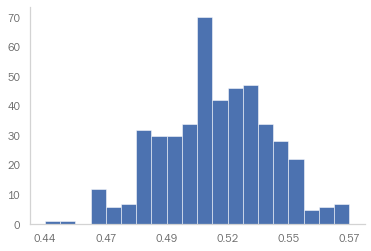

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

a = results[:, 3].astype(float)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(np.arange(min(a), max(a)+1, (max(a)-min(a))/5))
ax.hist(a, bins=20, linewidth=0.5, edgecolor="white")
plt.show()


In [1]:
# Using LSTM instead
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

def testAll_lstm(symbols, x1, x3):
    results = list()
    i = 0
    earlyStop=EarlyStopping(monitor="val_accuracy",verbose=2,mode='max',patience=5,restore_best_weights=True)
    for s in symbols:
        i = i + 1
        tickers = [[s],['EURUSD=X', 'JPY=X', 'ZC=F', 'HG=F', 'CL=F', 'GC=F', '^GDAXI', '^FTSE', 'SI=F', '^GSPC', '^DJI']]
#         x1 = marketInformation("10Y", tickers)
        try:
            hist = yf.Ticker(s).history(period="10Y")["Close"]
        except:
            print(f"Cannot get info of {s}, symbol is likely delisted")
            continue
        if hist.shape[0] <= 2500: # Less than 10 years of data
            print(hist.shape[0])
            continue
        hist = np.log(hist / hist.shift(periods=1))
        x1_ = x1.copy()
        x1_[s] = hist
        x2 = technicalInformation("10Y", tickers[0][0])
#         x3 = interestInformation(tickers[0][0])
        x4 = technical2("10Y", tickers[0][0])
        Xp, yp = allFactors(x1_, x2, x3, x4, tickers[0][0])
        if Xp.shape[0] != yp.shape[0] or Xp.shape[0] < 2400:
            print('Poor data')
            x1_ = x1_.drop(columns=[s])
            continue
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xp, yp = rfe(Xtrain, ytrain, Xp, yp)
        Xtrain = Xp[0:1500, :]
        ytrain = yp[0:1500]
        Xval = Xp[1500:1900, :]
        yval = yp[1500:1900]
        Xtest = Xp[1900:2400, :]
        ytest = yp[1900:2400]
#         ratio = min(ytrain.mean(), 1-ytrain.mean())/max(ytrain.mean(), 1-ytrain.mean())+0.01
#         if (ratio < 0.9):
#             ros = imblearn.over_sampling.SMOTE(sampling_strategy=min(ratio, 1), random_state=1)
#             Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)
        
        Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
        Xval = Xval.reshape((Xval.shape[0], 1, Xval.shape[1]))
        Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
        model = Sequential()
        model.add(LSTM(8, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(Xtrain, ytrain, epochs=20, batch_size=16, validation_data=(Xtest, ytest), verbose=0, shuffle=False, callbacks=[earlyStop])
        pred = (model.predict(Xtest)>0.5)*1
        results.append([s, accuracy((model.predict(Xtrain)>0.5)*1, ytrain), accuracy((model.predict(Xval)>0.5)*1, yval), 
                        accuracy(pred, ytest), 
                        max(np.mean(ytest), 1-np.mean(ytest)), x1_[tickers[0][0]].corr(x1['^GSPC']), pred.mean(), 
                        sklearn.metrics.recall_score(ytest, pred), 
                        sklearn.metrics.precision_score(ytest, pred), 
                        sklearn.metrics.f1_score(ytest, pred)])
        x1_ = x1_.drop(columns=[s])
        if i % 10 == 0:
            print(i)
    return results
    

results = testAll_lstm(symbols, x1, x3)

In [39]:
results = np.asarray(results)
print(results[:, 1].astype(float).mean()) # Train accuracy
print(results[:, 2].astype(float).mean()) # Validation accuracy
print(results[:, 3].astype(float).mean()) # Test accuracy
print(results[:, 4].astype(float).mean()) # ytest average
print(results[:, 5].astype(float).mean()) # Average Correlation between S&P 500 index and the specified stocks
print(results[:, 6].astype(float).mean()) # Average direction of predictions
print(results[:, 7].astype(float).mean()) # Recall
print(results[:, 8].astype(float).mean()) # Precision
print(results[:, 9].astype(float).mean()) # f1_score

0.5675101449275363
0.5149782608695652
0.5261173913043479
0.5266913043478262
0.585004939458233
0.627608695652174
0.6448439998129392
0.5400288761422831
0.5625940775362855


In [42]:
np.savez('results', results)